In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import re

import copy

import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_data=False)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',palette='bright',style='ticks')

import tqdm

from scipy.stats import norm
from sklearn.cluster import AffinityPropagation

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']

In [3]:
from AFL.automation import prepare
from AFL.automation.APIServer import DummyDriver
from AFL.automation.instrument import VirtualSANS_data
from AFL.automation.shared.units import units,is_concentration,is_volume,is_mass
from AFL.agent.AgentClient import AgentClient
from AFL.agent import xarray_extensions, GaussianProcess
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction
from AFL.automation.APIServer.Client import Client

In [4]:
from SAS_model_fit_driver import SAS_model_fit, sas_wrapper
import sasmodels

## Server instantiation

In [5]:
netcdf_path = '/Users/drs18/Documents/multimodal-dev/phasemap_P188_2D_MultiModal_UCB_noThomp_FixedP188_30524b88-00f7-4606-9c4d-57ad7880f95e.nc'
model_ds = xr.load_dataset(netcdf_path)

sasfit_url = 'localhost:5058'
sasfit_client = Client(sasfit_url.split(':')[0],port=sasfit_url.split(':')[1])
sasfit_client.login('SampleServer_SASfit_Client')
sasfit_client.debug(False)
sasfit_client.set_config(
    filepath='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    save_path='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    q_range = (model_ds.q.min().values.tolist(), model_ds.q.max().values.tolist()),
    model_inputs = [{
        'name':'power_law_1',
        'sasmodel':'power_law',
        'fit_params':{
            'power':{
                'value':4,
                'bounds':(3,4.5)
            },
            'background':{
                'value':1e-4,
                'bounds':(1e-10,1e2)
            },
            'scale':{
                'value':1e0,
                'bounds':(1e-6,1e4)
            }
        }
    }]
)


sasfit_client.set_driver_object(dataset=model_ds)
sasfit_client.set_driver_object(clustered=True)

<Response [200]>

## test startup and base functions

In [150]:
sasfit_client.enqueue(task_name='construct_models')

UUID('1a3c9f3f-8c36-41a3-be3e-507d1b987211')

In [238]:
config = sasfit_client.get_config('all',interactive=True)

In [239]:
dummy_model = config['return_val']['model_inputs'][0]
add_model = dummy_model
# print(add_model)
add_model['name'] = 'power_law_2'
add_model['fit_params']['power'] = {'value':2, 'bounds':[1,3]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])

add_model['name'] = 'power_law_3'
add_model['fit_params']['power'] = {'value':800, 'bounds':[100,1000]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])


UUID('f14a9410-9839-4865-b566-1ba0316da4fd')

In [240]:
sasfit_client.enqueue(task_name='remove_model',name='power_law_3')

UUID('9473a90e-6b59-4595-a4e2-459e00e35672')

## Test on real data with fitting

In [246]:
data = []
for idx in range(len(model_ds.SAS)):
    
    q = model_ds.q.values#[:-25]
    I = model_ds.SAS[idx].values#[:-25]
    dI = 0.1 * I
    data.append(np.vstack([q,I,dI]).T.tolist())
# data = sasmodels.data.Data1D(x=q,y=I,dy=dI) 
initial_models = [
    {'name':"polymer_micelle_1",
     'sasmodel':'polymer_micelle',
     'fit_params':{
            "scale"       : {'value':2*max(I), 'bounds':(1e-1,1e4)},
            "background"  : {'value':50,       'bounds':(1e-1,1e4)},
            "radius_core" : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            "sld_core"    : {'value':5.45,     'bounds':None},
            "sld_corona"  : {'value':5.15,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
     }
    },
    {'name':"small_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
            "scale"       : {'value':max(I),   'bounds':(1e-1,1e4)},
            "background"  : {'value':20,       'bounds':(1e1,1e2)},
            "radius"      : {'value':50,       'bounds':(1e-1,1e3)},
            "radius_pd"   : {'value':0.15,       'bounds':(0.02,0.5)},
            "radius_pd_type": {'value':'gaussian','bounds':None},
            "radius_pd_n": {'value':15,'bounds':None},
            "sld"         : {'value':5.45,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
        }
    },
    {'name':"poly_gauss_coil_1",
     'sasmodel':'poly_gauss_coil',
     'fit_params':{
            "i_zero"      : {'value':max(I),   'bounds':(1e-1,1e4)},
            "background"  : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            # "polydispersity": {'value':1,       'bounds':(0.5,2)}
        }
    }
]

In [247]:
sasfit_client.set_config(model_inputs=initial_models)

UUID('45ca278a-e71d-4963-b0fd-ad0bab788333')

In [248]:
sasfit_client.enqueue(task_name='construct_models')

UUID('81c61ebe-ae18-4d91-8820-2f7cca0a38ef')

### batch fitting (something's wrong...)

In [249]:
fit_method={'method':'lm',
            'steps':1000,
            'ftol': 1.5e-6,
            'xtol': 1.5e-6,
            'verbose':True
           }
data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(len(model_ds.SAS))]
sasfit_client.enqueue(task_name="fit_models",data=data[:5],
                      data_ID=data_ID[:5],
                     fit_method=fit_method)

UUID('de25b775-3cb5-4f9f-9342-151fd39d8c51')

In [186]:
sasfit_client.enqueue(task_name='build_report')
report_json = sasfit_client.get_driver_object('report')
model_inputs=report_json['model_inputs']
model_fits = report_json['model_fits']


In [220]:
x = {}
x['a'] = {}
x['a']['bounds'] = None
if 'bounds' in list(x['a']):
    print('gucci')
    x['a']['error'] = x['a']['bounds']
    del x['a']['bounds']
if 'bounds' not in list(x['a']):
    print('not gucci')
    

gucci
not gucci


## Report pull and reconstituting

Human readable analysis and reporting


scale 9999.158090449013
background 23.93328721472741
radius_core 54.77809548982547
rg 120.8811973541811
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 1.8968985826328248
background 37.97220906853465
radius 40.34715683643009
radius_pd 0.4999557802094242
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9999.480937644828
background 48.553840094520865
rg 893.1034190904555


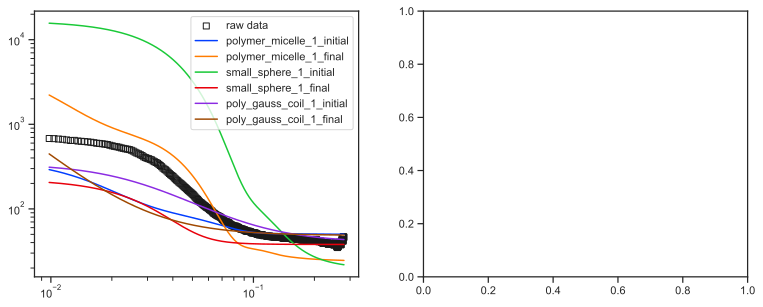


scale 9999.158090449013
background 23.93328721472741
radius_core 54.77809548982547
rg 120.8811973541811
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 1.8968985826328248
background 37.97220906853465
radius 40.34715683643009
radius_pd 0.4999557802094242
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9999.480937644828
background 48.553840094520865
rg 893.1034190904555


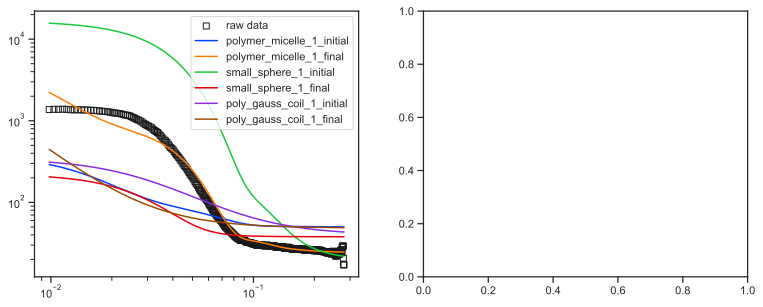


scale 9999.158090449013
background 23.93328721472741
radius_core 54.77809548982547
rg 120.8811973541811
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 1.8968985826328248
background 37.97220906853465
radius 40.34715683643009
radius_pd 0.4999557802094242
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9999.480937644828
background 48.553840094520865
rg 893.1034190904555


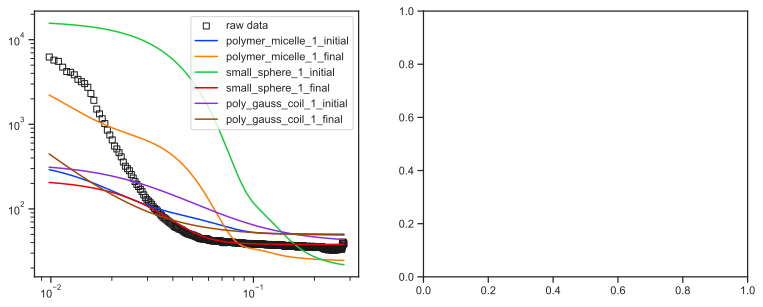


scale 9999.158090449013
background 23.93328721472741
radius_core 54.77809548982547
rg 120.8811973541811
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 1.8968985826328248
background 37.97220906853465
radius 40.34715683643009
radius_pd 0.4999557802094242
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9999.480937644828
background 48.553840094520865
rg 893.1034190904555


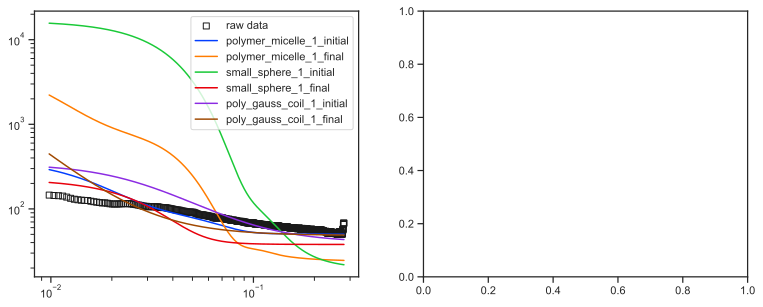


scale 9999.158090449013
background 23.93328721472741
radius_core 54.77809548982547
rg 120.8811973541811
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 1.8968985826328248
background 37.97220906853465
radius 40.34715683643009
radius_pd 0.4999557802094242
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 9999.480937644828
background 48.553840094520865
rg 893.1034190904555


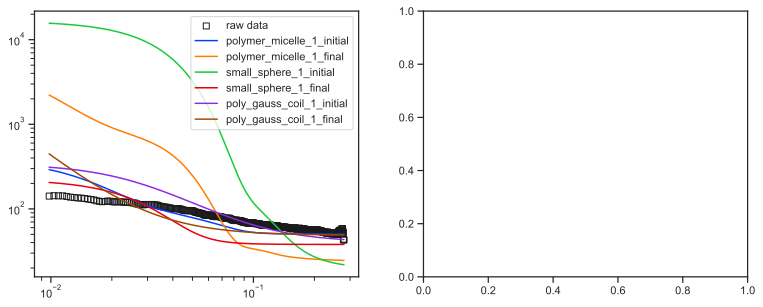

In [175]:
for idx in range(5):
    
    fit_method={'method':'lm',
                'steps':10000,
                'ftol': 1.5e-6,
                'xtol': 1.5e-6,
                'verbose':True
               }
    
    
    # data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(len(model_ds.SAS))]
    # sasfit_client.enqueue(task_name="fit_models",data=[data[idx]],
    #                       data_ID=['data_1'],
    #                      fit_method=fit_method)
    
    
    # sasfit_client.enqueue(task_name='build_report')
    # report_json = sasfit_client.get_driver_object('report')
    
    fit_method= report_json['fit_method']
    print()
    model_starts = report_json['model_inputs']
    fit_results = report_json['model_fits'][idx]
    empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(model_ds.q.values.min()),
                                                         np.log10(model_ds.q.values.max()),
                                                         1000
                                                        ))
    
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,model_ds.SAS[idx].values,label='raw data',color='k',marker='s',facecolors='none')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = fit_results[mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model['output_fit_params']):
            print(key, fit_model['output_fit_params'][key]['value'])
            params_final[key] = {'value':fit_model['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model['name'],
            sasmodel_type=fit_model['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            xscale='log',
            yscale='log'
        )
        ax[0].legend()
    plt.show(fig)
    plt.close(fig)

## Serial Fitting

In [ ]:
sasfit_client.enqueue(task_name='build_report')
report_json = sasfit_client.get_driver_object('report')
report_json
fit_method= report_json['fit_method']
model_starts = report_json['model_inputs']
fit_results = report_json['model_fits']
empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(model_ds.q.values.min()),
                                                     np.log10(model_ds.q.values.max()),
                                                     1000
                                                    ))
for idx in range(len(model_ds.SAS.values)):
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,model_ds.SAS[idx].values,label='raw data')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = fit_results[mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model[mdx]['output_fit_params']):
            params_final[key] = {'value':fit_model[mdx]['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model[mdx]['name'],
            sasmodel_type=fit_model[mdx]['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            xscale='log',
            yscale='log'
        )
        ax[0].legend()
    plt.show(fig)
    plt.close(fig)

[0.10901291008439683, 0.4666097823923236, 1.4276706821023006] 0 polymer_micelle_1
[1.5796703532257839, 2.8008062189137344, 7.610963666871448] 0 polymer_micelle_1
[240.50111473440015, 2.6669240807387435, 4.2167754516434215] 1 small_sphere_1
[589.0080232106926, 19.82083824548737, 6.921357775311741] 2 poly_gauss_coil_1
[551.4233011171323, 12.986913851906541, 6.803085921655831] 2 poly_gauss_coil_1
[706.1922602934334, 6.028173140784286, 6.859588526077948] 1 small_sphere_1
[601.1235011580019, 3.318372031259583, 6.586875424755204] 1 small_sphere_1
[618.2655813773314, 0.991923320840426, 6.116537457279797] 1 small_sphere_1
[2.147048455788609, 12.365805119131792, 41.59374120827924] 0 polymer_micelle_1
[31.4664937425923, 3.8337061648000783, 10.477807592361469] 1 small_sphere_1
[378.5663401558229, 11.24442383777559, 6.139409342537034] 2 poly_gauss_coil_1
[83.69993058363599, 4.49672756001287, 8.846923893896859] 1 small_sphere_1
[8.701593251151465, 0.7618174531008985, 15.304630253281633] 1 small_sph

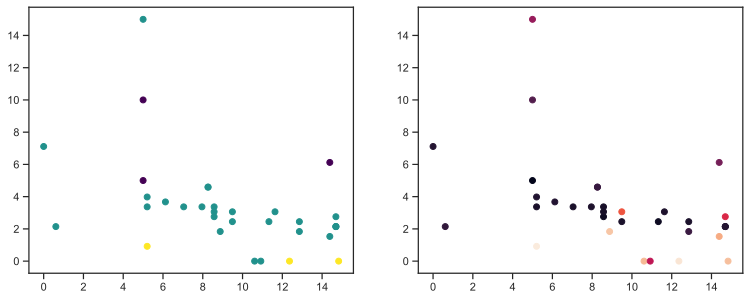

In [506]:
labels = []
ID = []
chisqr = []

for fit in sasfit_client.get_driver_object('results'):
    all_chisq = [fit[mdx]['chisq'] for mdx in range(len(fit))]
    best_idx = np.nanargmin(all_chisq)
    best_model = fit[best_idx]['name']
    print(all_chisq,best_idx,best_model)
    labels.append(best_model)
    ID.append(best_idx)
    chisqr.append(np.min(all_chisq))

x,y = model_ds.benzyl_alcohol_solute.values, model_ds.phenol_solute.values
# x,y = x[:3],y[:3]
fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
ax[0].scatter(x,y,c=ID,label=labels,cmap='viridis')
ax[1].scatter(x,y,c=chisqr)

In [507]:
test = sasfit_client.get_config('model_inputs')